# 第5章 ロジスティック回帰とROC曲線：学習モデルの評価方法

## 5.2 ROC曲線による分類アルゴリズムの評価

**[05RC-01]**

必要なモジュールをインポートします。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

from numpy.random import multivariate_normal

**[05RC-02]**

トレーニングセットのデータを生成する関数を用意します。

平面上の ○ ☓ の 2 種類のデータについて、それぞれの「個数、中心座標、分散」を引数で指定します。

In [2]:
def prepare_dataset(n1, mu1, variance1, n2, mu2, variance2):
  df1 = DataFrame(multivariate_normal(mu1, np.eye(2)*variance1 ,n1),
                  columns=['x', 'y'])
  df1['type'] = 1
  df2 = DataFrame(multivariate_normal(mu2, np.eye(2)*variance2, n2),
                  columns=['x', 'y'])
  df2['type'] = -1
  df = pd.concat([df1, df2], ignore_index=True)
  df = df.reindex(np.random.permutation(df.index)).reset_index(drop=True)
  return df

**[05RC-03]**

ロジスティック回帰で分割線を決定する関数を用意します。

トレーニングセットのデータを受け渡すと、下記の一次関数 $f(x,\,y)$ に対するパラメーター $(w_0,\,w_1,\,w_2)$ を格納した array オブジェクトを返します。

$$ f(x,\,y) = w_0 + w_1x + w_2y$$

In [3]:
def run_logistic(train_set):
  w = np.array([0, 0, 0])
  phi = train_set[['x', 'y']]
  phi['bias'] = 1
  phi = phi[['bias', 'x', 'y']].values
  t = (train_set['type'].values+1)*0.5 # type = 1, -1 を type = 1, 0 に変換

  # 最大30回のIterationを実施
  for i in range(30):
    # IRLS法によるパラメータの修正
    z = np.array([1.0/(1.0+np.exp(-np.dot(w, line))) for line in phi])
    r = np.diag(z*(1-z)) 
    tmp1 = np.linalg.inv(np.dot(np.dot(phi.T, r), phi))
    tmp2 = np.dot(phi.T, (z-t))
    w_new = w - np.dot(tmp1, tmp2)
    # パラメータの変化が 0.1% 未満になったら終了
    if np.dot(w_new-w, w_new-w) < 0.001*np.dot(w, w):
      break
    w = w_new

  return w

**[05RC-04]**

結果をグラフに表示する関数を用意します。

In [4]:
# 判定誤差の計算
def err_rate(w0, w1, w2):
  err = 0.0
  for index, point in train_set.iterrows():
    x, y, type = point.x, point.y, point.type
    if (w0 + w1*x + w2*y) * type <= 0:
      err += 1
  return err * 100 / len(train_set)

# 結果の表示
def show_result(subplot, train_set, w):
  train_set1 = train_set[train_set['type']==1]
  train_set2 = train_set[train_set['type']==-1]
  xmin, xmax = train_set.x.min()-5, train_set.x.max()+10
  ymin, ymax = train_set.y.min()-5, train_set.y.max()+10

  subplot.tick_params(axis='x', labelsize=14)
  subplot.tick_params(axis='y', labelsize=14)
  subplot.set_xlim([xmin-1, xmax+1])
  subplot.set_ylim([ymin-1, ymax+1])
  subplot.scatter(train_set1.x, train_set1.y, marker='o', label=None)
  subplot.scatter(train_set2.x, train_set2.y, marker='x', label=None)

  w0, w1, w2 = w.tolist()
  linex = np.arange(xmin-5, xmax+5)
  liney = - linex * w1 / w2 - w0 / w2
  label = "ERR %.2f%%" % err_rate(w0, w1, w2)
  subplot.plot(linex, liney, label=label, color='red')

  subplot.legend(loc=1, fontsize=14)

**[05RC-05]**

ROC曲線を表示する関数を用意します。

In [5]:
# ROC曲線の表示
def draw_roc(subplot, train_set, w):
  phi = train_set[['x', 'y']]
  phi['bias'] = 1
  phi = phi[['bias', 'x', 'y']].values
  z = np.array([1.0/(1.0+np.exp(-np.dot(w, line))) for line in phi])
  result = train_set.copy()
  result['probability'] = z
  result = result.sort_values(
      by=['probability'], ascending=[False]).reset_index(drop=True)

  positives = len(result[result['type']==1])
  negatives = len(result[result['type']==-1])
  tp = [0.0] * len(result)
  fp = [0.0] * len(result)
  for index, line in result.iterrows():
    for c in np.arange(0, len(result)):
      if index < c:
        if line.type == 1:
          tp[c] += 1
        else:
          fp[c] += 1
  tp_rate = np.array(tp) / positives
  fp_rate = np.array(fp) / negatives
  
  subplot.set_aspect('equal')
  subplot.tick_params(axis='x', labelsize=14)
  subplot.tick_params(axis='y', labelsize=14)
  subplot.set_xlim([0, 1])
  subplot.set_ylim([0, 1])
  subplot.set_xlabel('False positive rate', fontsize=14)
  subplot.set_ylabel('True positive rate', fontsize=14)
  subplot.plot(fp_rate, tp_rate)

**[05RC-06]**

比較的分散が小さくて、分類が容易なトレーニングセットを用意した上で、ロジスティック回帰を適用した結果を表示します。

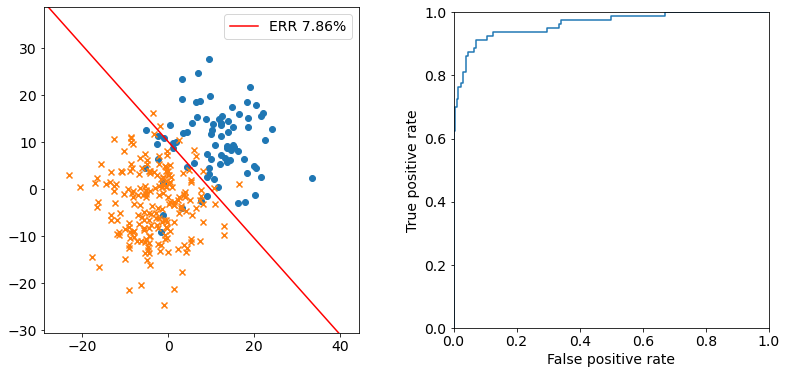

In [6]:
train_set = prepare_dataset(80, [9, 9], 50, 200, [-3, -3], 50)
w = run_logistic(train_set)
fig = plt.figure(figsize=(13, 6))
fig.subplots_adjust(wspace=0.3)
subplot = fig.add_subplot(1, 2, 1)
show_result(subplot, train_set, w)
subplot = fig.add_subplot(1, 2, 2)
draw_roc(subplot, train_set, w)

**[05RC-07]**

分散が大きくて、分類が困難なトレーニングセットをを用意した上で、ロジスティック回帰を適用した結果を表示します。

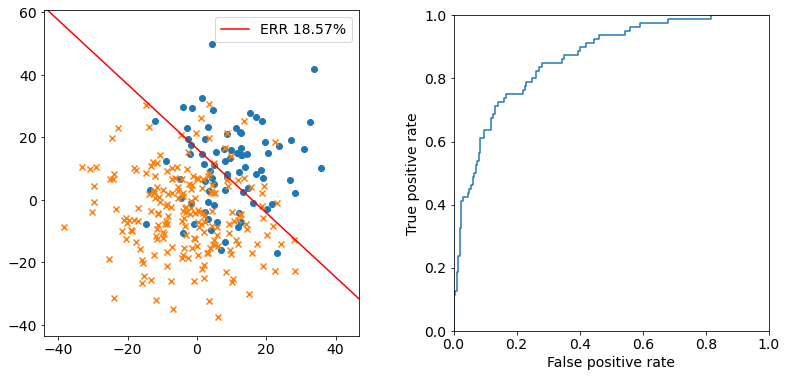

In [7]:
train_set = prepare_dataset(80, [9, 9], 150, 200, [-3, -3], 150)
w = run_logistic(train_set)
fig = plt.figure(figsize=(13, 6))
fig.subplots_adjust(wspace=0.3)
subplot = fig.add_subplot(1, 2, 1)
show_result(subplot, train_set, w)
subplot = fig.add_subplot(1, 2, 2)
draw_roc(subplot, train_set, w)